# Input:1 Output:1

In [16]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [3]:
# load data --------------------------------------------------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size 

# spatial slicing dimensions
os = 1 # output slice size
ts = os # total input slice 1
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 4096 # number of slices in one profile 



In [4]:
print("train_size:",train_size)
print("test_size:",test_size)

train_size: 3200
test_size: 800


In [5]:
# spatial slicing the profiles---------------------------------------------------------------------

image=np.zeros((l2r*num,ts,nchan)) 
label=np.zeros((l2r*num,os)) 

for i in range(num):
    for a in range(l2r):
#cut each profile into 4096 slices. 
#label: tau channel 
#1profile ..2profile...3 profile

        img= data[i, a*os:a*os+ts, 0:nchan] #input: 1 pixels for one slice, 3 channels 
        lb = data[i, a*os:a*os+os, nchan] #1 pixels for label,the tau channel is the label
        image[i*l2r+a]=img
        label[i*l2r+a]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) 

whole dataset features size:  (16384000, 1, 3) whole dataset label size:  (16384000, 1)


In [6]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [9]:
model=keras.Sequential()
model.add(keras.Input(shape=(ts,nchan)))
model.add(Bidirectional(layers.LSTM(units=60, activation='tanh',return_sequences = True,input_shape=(ts,nchan)))) #kernel size 6, 100 filters for each 3 channel
model.add(Bidirectional(layers.LSTM(units=60, activation='tanh'))) #kernel size 6, 100 filters for each 3 channel
#model.add(layers.Flatten())
model.add(layers.Dense(os, activation="linear"))#output slice size : 8
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 1, 120)            30720     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 120)               86880     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
Total params: 117,721
Trainable params: 117,721
Non-trainable params: 0
_________________________________________________________________


In [10]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [19]:
# Bi-LSTM ------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    model=keras.Sequential()
    #model.add(layers.Embedding(input_dim=24,output_dim=72,input_shape=(ts,nchan)))
    model.add(Bidirectional(layers.LSTM(units=60, activation='tanh',return_sequences = True,input_shape=(ts,nchan)))) #kernel size 6, 100 filters for each 3 channel
    model.add(Bidirectional(layers.LSTM(units=60, activation='tanh'))) #kernel size 6, 100 filters for each 3 channel
    #model.add(layers.Flatten())
    model.add(layers.Dense(os, activation="linear"))#output slice size : 8

    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 2000

    model.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [22]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(image),'folds cross validation')
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),ts,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts,3))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

5 folds cross validation
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 3276800  3276801  3276802 ... 16383997 16383998 16383999] TEST: [      0       1       2 ... 3276797 3276798 3276799]
TRAIN: [       0        1        2 ... 16383997 16383998 16383999] TEST: [3276800 3276801 3276802 ... 6553597 6553598 6553599]
TRAIN: [       0        1        2 ... 16383997 16383998 16383999] TEST: [6553600 6553601 6553602 ... 9830397 9830398 9830399]
TRAIN: [       0        1        2 ... 16383997 16383998 16383999] TEST: [ 9830400  9830401  9830402 ... 13107197 13107198 13107199]
TRAIN: [       0        1        2 ... 13107197 13107198 13107199] TEST: [13107200 13107201 13107202 ... 16383997 16383998 16383999]


In [23]:
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Epoch 1/2000
11200/11200 [==============================] - 109s 9ms/step - loss: 25.6413 - mean_squared_error: 25.6413 - root_mean_squared_error: 5.0224 - val_loss: 16.7715 - val_mean_squared_error: 16.7715 - val_root_mean_squared_error: 4.0953
Epoch 2/2000
11200/11200 [==============================] - 99s 9ms/step - loss: 21.4188 - mean_squared_error: 21.4188 - root_mean_squared_error: 4.6280 - val_loss: 16.6624 - val_mean_squared_error: 16.6624 - val_root_mean_squared_error: 4.0820
Epoch 3/2000
11200/11200 [==============================] - 101s 9ms/step - loss: 21.1869 - mean_squared_error: 21.1869 - root_mean_squared_error: 4.6029 - val_loss: 15.9694 - val_mean_squared_error: 15.9694 - val_root_mean_squared_error: 3.9962
Epoch 4/2000
11200/11200 [==============================] - 100s 9ms/step - loss: 18.0515 - mean_squared_error: 18.0515 - root_mean_squared_error: 4.2485 - val_loss: 13.6166 - val_mean_squared_error: 13.6166 - val_root_mean_squared_error: 3.6901
Epoch 5/2000
1120

11200/11200 [==============================] - 97s 9ms/step - loss: 13.7408 - mean_squared_error: 13.7408 - root_mean_squared_error: 3.7068 - val_loss: 11.7147 - val_mean_squared_error: 11.7147 - val_root_mean_squared_error: 3.4227
Epoch 68/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.6003 - mean_squared_error: 13.6003 - root_mean_squared_error: 3.6878 - val_loss: 11.5451 - val_mean_squared_error: 11.5451 - val_root_mean_squared_error: 3.3978
Epoch 69/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.6696 - mean_squared_error: 13.6696 - root_mean_squared_error: 3.6972 - val_loss: 11.6194 - val_mean_squared_error: 11.6194 - val_root_mean_squared_error: 3.4087
Epoch 70/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.6242 - mean_squared_error: 13.6242 - root_mean_squared_error: 3.6911 - val_loss: 11.7419 - val_mean_squared_error: 11.7419 - val_root_mean_squared_error: 3.4266
Epoch 71/2000
11200/11200 [===

11200/11200 [==============================] - 96s 9ms/step - loss: 13.1126 - mean_squared_error: 13.1126 - root_mean_squared_error: 3.6211 - val_loss: 12.0601 - val_mean_squared_error: 12.0601 - val_root_mean_squared_error: 3.4728
Epoch 33/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.0138 - mean_squared_error: 13.0138 - root_mean_squared_error: 3.6074 - val_loss: 12.0462 - val_mean_squared_error: 12.0462 - val_root_mean_squared_error: 3.4708
Epoch 34/2000
11200/11200 [==============================] - 97s 9ms/step - loss: 13.0443 - mean_squared_error: 13.0443 - root_mean_squared_error: 3.6117 - val_loss: 11.8083 - val_mean_squared_error: 11.8083 - val_root_mean_squared_error: 3.4363
Epoch 35/2000
11200/11200 [==============================] - 97s 9ms/step - loss: 13.0008 - mean_squared_error: 13.0008 - root_mean_squared_error: 3.6056 - val_loss: 11.7554 - val_mean_squared_error: 11.7554 - val_root_mean_squared_error: 3.4286
Epoch 36/2000
11200/11200 [===

11200/11200 [==============================] - 104s 9ms/step - loss: 25.9983 - mean_squared_error: 25.9983 - root_mean_squared_error: 5.0548 - val_loss: 16.9166 - val_mean_squared_error: 16.9166 - val_root_mean_squared_error: 4.1130
Epoch 2/2000
11200/11200 [==============================] - 95s 9ms/step - loss: 21.4883 - mean_squared_error: 21.4883 - root_mean_squared_error: 4.6355 - val_loss: 16.7827 - val_mean_squared_error: 16.7827 - val_root_mean_squared_error: 4.0967
Epoch 3/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 21.2684 - mean_squared_error: 21.2684 - root_mean_squared_error: 4.6117 - val_loss: 15.3820 - val_mean_squared_error: 15.3820 - val_root_mean_squared_error: 3.9220
Epoch 4/2000
11200/11200 [==============================] - 95s 9ms/step - loss: 18.3041 - mean_squared_error: 18.3041 - root_mean_squared_error: 4.2782 - val_loss: 14.5844 - val_mean_squared_error: 14.5844 - val_root_mean_squared_error: 3.8189
Epoch 5/2000
11200/11200 [======

11200/11200 [==============================] - 95s 9ms/step - loss: 13.6480 - mean_squared_error: 13.6480 - root_mean_squared_error: 3.6943 - val_loss: 11.6711 - val_mean_squared_error: 11.6711 - val_root_mean_squared_error: 3.4163
Epoch 68/2000
11200/11200 [==============================] - 95s 9ms/step - loss: 13.6519 - mean_squared_error: 13.6519 - root_mean_squared_error: 3.6948 - val_loss: 12.1505 - val_mean_squared_error: 12.1505 - val_root_mean_squared_error: 3.4858
Epoch 69/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.6125 - mean_squared_error: 13.6125 - root_mean_squared_error: 3.6895 - val_loss: 12.1295 - val_mean_squared_error: 12.1295 - val_root_mean_squared_error: 3.4827
Epoch 70/2000
11200/11200 [==============================] - 95s 9ms/step - loss: 13.6072 - mean_squared_error: 13.6072 - root_mean_squared_error: 3.6888 - val_loss: 11.6320 - val_mean_squared_error: 11.6320 - val_root_mean_squared_error: 3.4106
Epoch 71/2000
11200/11200 [===

11200/11200 [==============================] - 98s 9ms/step - loss: 13.5425 - mean_squared_error: 13.5425 - root_mean_squared_error: 3.6800 - val_loss: 12.2569 - val_mean_squared_error: 12.2569 - val_root_mean_squared_error: 3.5010
Epoch 19/2000
11200/11200 [==============================] - 98s 9ms/step - loss: 13.4702 - mean_squared_error: 13.4702 - root_mean_squared_error: 3.6702 - val_loss: 11.6793 - val_mean_squared_error: 11.6793 - val_root_mean_squared_error: 3.4175
Epoch 20/2000
11200/11200 [==============================] - 98s 9ms/step - loss: 13.4825 - mean_squared_error: 13.4825 - root_mean_squared_error: 3.6718 - val_loss: 12.1940 - val_mean_squared_error: 12.1940 - val_root_mean_squared_error: 3.4920
Epoch 21/2000
11200/11200 [==============================] - 98s 9ms/step - loss: 13.5384 - mean_squared_error: 13.5384 - root_mean_squared_error: 3.6794 - val_loss: 11.7980 - val_mean_squared_error: 11.7980 - val_root_mean_squared_error: 3.4348
Epoch 22/2000
11200/11200 [===

11200/11200 [==============================] - 98s 9ms/step - loss: 13.1292 - mean_squared_error: 13.1292 - root_mean_squared_error: 3.6234 - val_loss: 11.5810 - val_mean_squared_error: 11.5810 - val_root_mean_squared_error: 3.4031
Epoch 85/2000
11200/11200 [==============================] - 98s 9ms/step - loss: 13.1209 - mean_squared_error: 13.1209 - root_mean_squared_error: 3.6222 - val_loss: 11.4762 - val_mean_squared_error: 11.4762 - val_root_mean_squared_error: 3.3876
Epoch 86/2000
11200/11200 [==============================] - 98s 9ms/step - loss: 13.1384 - mean_squared_error: 13.1384 - root_mean_squared_error: 3.6247 - val_loss: 11.3814 - val_mean_squared_error: 11.3814 - val_root_mean_squared_error: 3.3736
Epoch 87/2000
11200/11200 [==============================] - 98s 9ms/step - loss: 13.1119 - mean_squared_error: 13.1119 - root_mean_squared_error: 3.6210 - val_loss: 11.4768 - val_mean_squared_error: 11.4768 - val_root_mean_squared_error: 3.3877
Epoch 88/2000
11200/11200 [===

11200/11200 [==============================] - 97s 9ms/step - loss: 13.6730 - mean_squared_error: 13.6730 - root_mean_squared_error: 3.6977 - val_loss: 13.4145 - val_mean_squared_error: 13.4145 - val_root_mean_squared_error: 3.6626
Epoch 29/2000
11200/11200 [==============================] - 97s 9ms/step - loss: 13.6397 - mean_squared_error: 13.6397 - root_mean_squared_error: 3.6931 - val_loss: 13.5952 - val_mean_squared_error: 13.5952 - val_root_mean_squared_error: 3.6872
Epoch 30/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.6269 - mean_squared_error: 13.6269 - root_mean_squared_error: 3.6914 - val_loss: 13.3746 - val_mean_squared_error: 13.3746 - val_root_mean_squared_error: 3.6571
Epoch 31/2000
11200/11200 [==============================] - 97s 9ms/step - loss: 13.6237 - mean_squared_error: 13.6237 - root_mean_squared_error: 3.6910 - val_loss: 13.4380 - val_mean_squared_error: 13.4380 - val_root_mean_squared_error: 3.6658
Epoch 32/2000
11200/11200 [===

11200/11200 [==============================] - 96s 9ms/step - loss: 13.3565 - mean_squared_error: 13.3565 - root_mean_squared_error: 3.6546 - val_loss: 13.2458 - val_mean_squared_error: 13.2458 - val_root_mean_squared_error: 3.6395
Epoch 95/2000
11200/11200 [==============================] - 96s 9ms/step - loss: 13.3122 - mean_squared_error: 13.3122 - root_mean_squared_error: 3.6485 - val_loss: 14.5527 - val_mean_squared_error: 14.5527 - val_root_mean_squared_error: 3.8148
Epoch 96/2000
11200/11200 [==============================] - 97s 9ms/step - loss: 13.3365 - mean_squared_error: 13.3365 - root_mean_squared_error: 3.6519 - val_loss: 13.1722 - val_mean_squared_error: 13.1722 - val_root_mean_squared_error: 3.6293
Epoch 97/2000
11200/11200 [==============================] - 97s 9ms/step - loss: 13.3736 - mean_squared_error: 13.3736 - root_mean_squared_error: 3.6570 - val_loss: 13.6960 - val_mean_squared_error: 13.6960 - val_root_mean_squared_error: 3.7008
Epoch 98/2000
11200/11200 [===

In [31]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 13.0968 with standard deviation (1.2116)
Estimated RMSE 3.6152 with standard deviation (0.1651)


In [32]:
#quantitative reuslt: mean square error of test set
cv_scores

[12.118753433227539,
 15.094332695007324,
 12.214136123657227,
 13.924321174621582,
 12.132515907287598]

In [33]:
cv_scores2

[3.4811999797821045,
 3.8851425647735596,
 3.494872808456421,
 3.7315306663513184,
 3.4831762313842773]

The optimal number of epochs is 74


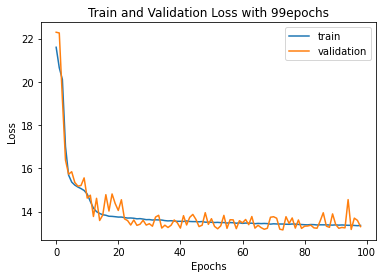

In [34]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [35]:
predict1=np.zeros((4096,))
for i in range((test_size-3)*l2r,(test_size-2)*l2r):
    predict1[(i-(test_size-3)*l2r)*os:(i-(test_size-3)*l2r+1)*os,]=predictions[i]
    
predict2=np.zeros((4096,))
for i in range((test_size-2)*l2r,(test_size-1)*l2r):
    predict2[(i-(test_size-2)*l2r)*os:(i-(test_size-2)*l2r+1)*os,]=predictions[i]
    
predict3=np.zeros((4096,))
for i in range((test_size-1)*l2r,test_size*l2r):
    predict3[(i-(test_size-1)*l2r)*os:(i-(test_size-1)*l2r+1)*os,]=predictions[i]

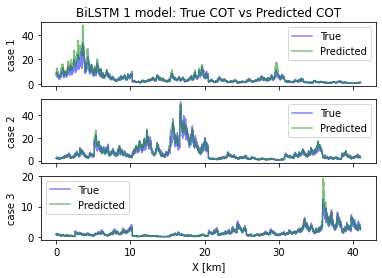

In [36]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/BiLSTM 1 predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"BiLSTM 1 model: True COT vs Predicted COT")
ax.plot(x[:os*l2r],data[num-3,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict1,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r],data[num-2,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict2,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r],data[num-1,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict3,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

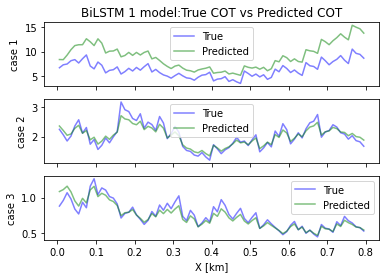

In [37]:
# plotting ----------------------------------------------------------------------------------------------------------------
fgnm = "plots/BiLSTM 1 predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"BiLSTM 1 model:True COT vs Predicted COT")
ax.plot(x[:os*l2r][:80],data[num-3,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict1[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r][:80],data[num-2,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict2[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r][:80],data[num-1,:os*l2r,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r][:80],predict3[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')
